In [147]:
#importing all the necessary model related packages
import tensorflow as tf 
import numpy as np 
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Reshape
from tensorflow.keras.optimizers import Adam


In [148]:
#importing necessary additional packages for pre-processing and other processes
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import PorterStemmer
import string
import pandas as pd
import numpy as np
import os
import copy
import re
import copy
import random

In [149]:
#importing stopwords and terms file(data dictionary for word embeddings). Both the files are converted to lists
terms=open("C:/Users/beera/Downloads/terms.txt").read().split('\n')
sw=open("C:/Users/beera/Downloads/stopwords.txt").read().split('\n')

In [150]:
#function to preprocess the input article

def preprocess(d):
 data=d.strip()                                                       # removing spaces
 data=data.split('\n')                                                # splitting the data on new lines 
 data=' '.join(data)                                                  # joning the splitted data with a space - paragraphs removes
 data=re.sub(r'([a-z!"$%)?\'])\.([A-Z])', r'\1. \2',data)             # modifying the data in the article as inputting space between fullstop and next sentence captial letter where the previous sentence ends with a small letter or a punctuation. Defined regular expression to handle this automatically.
 data=re.sub(r'([0-9])\. ([A-Z])', r'\1 . \2',data)                   # similarly, adding a space before and after a fullstop between a sentence ending with a number followed by a fullstop and then begins with another Capital letter.
 data=data.lower()                                                    # now lowering the data after required operations are done. If the above operations are not done, sent_tokenize fails to recognize the above cases as sentences
 data=nltk.sent_tokenize(data)                                        # tokenizing the text into sentences
 stemmer=PorterStemmer()                                                
 i=0
 for i in range(len(data)):
  data[i]=data[i].translate(str.maketrans('','', string.punctuation)) # remove punctuation from each sentence
  data[i]=nltk.word_tokenize(data[i])                                 # tokenize each word in a sentence
  rdata=[]                    
  for q in data[i]:
   if q not in sw:                                                    # removing stop words from the sentence
    rdata.append(q)
  data[i]=copy.deepcopy(rdata)                                        # deepcopying the data into the original position after removing stopwords
  j=0
  rdata=[]
  while(j<len(data[i])):
   data[i][j]=stemmer.stem(data[i][j])                                # stemming the words using PorterStemmer so we will be able to match them with the words in the data dictionary - terms file
   if data[i][j] in terms:
    rdata.append(terms.index(data[i][j])+1)                           # embedding the words into integers from the terms file as indices. NOTE: The index begins with 1 
    j+=1
   else:
    j+=1                                                              # if the stemmed word is not present in the terms list, simply skip it
  data[i]=copy.deepcopy(rdata)

 rectangle=np.zeros((246,500),dtype='int32')                          # declare a 246,500 numpy zeroes array
 for i in range(len(data)):
     rectangle[i:i+1,0:len(data[i])]=data[i]                          # include the data in place of the zero for the sentences - a sparse matrix is the result


 return rectangle

In [151]:
def preprocesssum(d): 
 data=d.strip()
 data=data.split('\n')
 data=' '.join(data)
 data=re.sub(r'([a-zA-Z])\.([A-Z])', r'\1. \2',data)
 data=re.sub(r'([0-9!"$%)?\'])\.([A-Z])', r'\1 . \2',data)
 data=data.lower()
 data=nltk.sent_tokenize(data)
 stemmer=PorterStemmer()
 i=0
 for i in range(len(data)):
  data[i]=data[i].translate(str.maketrans('','', string.punctuation))
  data[i]=nltk.word_tokenize(data[i])
  rdata=[]
  for q in data[i]:
   if q not in sw:
    rdata.append(q)
  data[i]=copy.deepcopy(rdata)
  j=0
  rdata=[]
  while(j<len(data[i])):
   data[i][j]=stemmer.stem(data[i][j])
   if data[i][j] in terms:
    rdata.append(terms.index(data[i][j])+1)
    j+=1
   else:
    j+=1
  data[i]=copy.deepcopy(rdata)
 
 rectangle=np.zeros((246,500),dtype='int32')
 for i in range(len(data)):
     rectangle[i:i+1,0:len(data[i])]=data[i]


 return rectangle

NOTE that pretest() and pretestsum() are preprocessing functions but do limited preprocessing on test data and produce data as follows:
pretest - input articles are sent_tokenized and returned which is later used to generate summary
pretestsum - output summaries are sent as input which are lowered and returned and are used as references.

In [152]:
def pretest(d):                                                            
 data=d.strip()
 data=data.split('\n')
 data=' '.join(data)
 data=re.sub(r'([a-z!"$%)?\'])\.([A-Z])', r'\1. \2',data)
 data=re.sub(r'([0-9])\. ([A-Z])', r'\1 . \2',data)
 data=data.lower()
 data=nltk.sent_tokenize(data)
 return data

In [153]:
def pretestsum(d):
 data=d.strip()
 data=data.split('\n')
 data=' '.join(data)
 data=re.sub(r'([a-zA-Z])\.([A-Z])', r'\1. \2',data)
 data=re.sub(r'([0-9!"$%)?\'])\.([A-Z])', r'\1 . \2',data)
 data=data.lower()
 return data

In [154]:
path=os.path.abspath(os.path.join("C:/Users/beera/Downloads/generated-data2/")) #loading datapath
tasks=['business','entertainment','politics','sport','tech']                    #defining tasks/topics in the dataset

In [155]:
for task in tasks:
 train_df=pd.read_csv(path+'\\bbc_'+task+'_train.csv',header=0,usecols=[1,2],nrows=300)   #loading training dataset
 test_df=pd.read_csv(path+'\\bbc_'+task+'_test.csv',header=0,usecols=[1,2],nrows=80)      #loading testing dataset
 print('Number of train sentences: ',len(train_df)) 
 print('Number of test sentences: ',len(test_df))
 if task=='business':                                                                     #for each task, identifying the type of task
  bus_train=train_df['article'].values                                                    #loading support input article data
  bustar_train=train_df['summary'].values                                                 #loading support output summary data
  bus_test=test_df['article'].values                                                      #loading query input article data
  bustar_test=test_df['summary'].values                                                   #loading query output summary data
  bustarget=copy.deepcopy(bustar_test)                                                    #loading query article data for generating summary
  businpu=copy.deepcopy(bus_test)                                                         #loading output summary for reference
  tasks[0]=[bus_train,bustar_train,bus_test,bustar_test,businpu,bustarget]                #adding the data into the dataset dictionary
 elif task=='politics':
  pol_train=train_df['article'].values
  poltar_train=train_df['summary'].values
  pol_test=test_df['article'].values
  poltar_test=test_df['summary'].values
  poltarget=copy.deepcopy(poltar_test)
  polinpu=copy.deepcopy(pol_test)
  tasks[2]=[pol_train,poltar_train,pol_test,poltar_test,polinpu,poltarget] 
 elif task=='entertainment':
  ent_train=train_df['article'].values
  enttar_train=train_df['summary'].values
  ent_test=test_df['article'].values
  enttar_test=test_df['summary'].values
  enttarget=copy.deepcopy(enttar_test)
  entinpu=copy.deepcopy(ent_test)
  tasks[1]=[ent_train,enttar_train,ent_test,enttar_test,entinpu,enttarget]
 elif task=='sport':
  spo_train=train_df['article'].values
  spotar_train=train_df['summary'].values
  spo_test=test_df['article'].values
  spotar_test=test_df['summary'].values
  spotarget=copy.deepcopy(spotar_test)
  spoinpu=copy.deepcopy(spo_test)
  tasks[3]=[spo_train,spotar_train,spo_test,spotar_test,spoinpu,spotarget]
 else:
  tec_train=train_df['article'].values
  tectar_train=train_df['summary'].values
  tec_test=test_df['article'].values
  tectar_test=test_df['summary'].values
  tectarget=copy.deepcopy(tectar_test)
  tecinpu=copy.deepcopy(tec_test)
  tasks[4]=[tec_train,tectar_train,tec_test,tectar_test,tecinpu,tectarget]

#creating a topic based data dictionary
'''
each topic in this dictionary consists of 6 datasets they are:-
1. training input data 
2. training output data
3. testing input data
4. testing output data
5. testing input data
6. testing output data

NOTE: 5 and 6 are essentially a deep copy of 3 and 4 respectively but are preprocessed in a different manner as they(5) are used to produce summaries from model predictions and
      the summaries are used for reference comparsions from 6.
'''
tasks={'business':copy.deepcopy(tasks[0]),'entertainment':copy.deepcopy(tasks[1]),'politics':copy.deepcopy(tasks[2]),'sport':copy.deepcopy(tasks[3]),'tech':copy.deepcopy(tasks[4])}

Number of train sentences:  300
Number of test sentences:  80
Number of train sentences:  300
Number of test sentences:  80
Number of train sentences:  300
Number of test sentences:  80
Number of train sentences:  300
Number of test sentences:  80
Number of train sentences:  300
Number of test sentences:  80


In [157]:
for task in tasks.keys():
 for i in range(0,len(tasks[task][0])):                                                  #performing preprocessing on input support articles
  rectangle=np.zeros((246),dtype='int32')                                                #defining a matrix of zeroes of 246 x 500 shape
  tasks[task][0][i]=preprocess(tasks[task][0][i]).tolist()                               
  tasks[task][1][i]=preprocesssum(tasks[task][1][i]).tolist()
  for j in range(0,len(tasks[task][0][i])):
   if(tasks[task][0][i][j].count(0)<500 and tasks[task][0][i][j] in tasks[task][1][i]):  #determining wether a sentence from input is present in the output or not and setting the coressponding value as 1 in the defined matrix
    rectangle[j]=1
  tasks[task][0][i]=tf.convert_to_tensor(tasks[task][0][i],dtype='int32')                #converting the data into a tensor
  tasks[task][1][i]=tf.convert_to_tensor(rectangle,dtype='int32')

In [158]:
for task in tasks:
 for i in range(0,len(tasks[task][2])):                                                  #performing preprocessing on output summaries
  tasks[task][4][i]=pretest(tasks[task][4][i])                                           #limited preprocessing for input article
  tasks[task][5][i]=pretestsum(tasks[task][5][i])                                        #limited preprocessing for ouput summary
  rectangle=np.zeros((246),dtype='int32')
  tasks[task][2][i]=preprocess(tasks[task][2][i]).tolist()                
  tasks[task][3][i]=preprocesssum(tasks[task][3][i]).tolist()
  for j in range(0,len(tasks[task][2][i])):
   if(tasks[task][2][i][j].count(0)<500 and tasks[task][2][i][j] in tasks[task][3][i]):
    rectangle[j]=1
  tasks[task][2][i]=tf.convert_to_tensor(tasks[task][2][i],dtype='int32')
  tasks[task][3][i]=tf.convert_to_tensor(rectangle,dtype='int32')

In [160]:
inner_lr=0.001
meta_lr=0.001 
num_inner_updates=10  # Number of gradient descent steps in inner loop

optimizer=tf.keras.optimizers.Adam(learning_rate=meta_lr)

In [161]:
#Input layer
input_layer=Input(shape=(246,500))

#BiLSTM layer
bi_lstm=Bidirectional(LSTM(128,return_sequences=True))(input_layer)

#Dense layer
dense_layer=Dense(1,activation='sigmoid')(bi_lstm)

#Reshape layer
reshape_layer=Reshape((246,))(dense_layer)

#Create the model
model=tf.keras.Model(inputs=input_layer,outputs=reshape_layer)

#Compiling the model 
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

#Display the model summary
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 246, 500)]        0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 246, 256)          644096    
 onal)                                                           
                                                                 
 dense_5 (Dense)             (None, 246, 1)            257       
                                                                 
 reshape_5 (Reshape)         (None, 246)               0         
                                                                 
Total params: 644353 (2.46 MB)
Trainable params: 644353 (2.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [162]:
epochs=10
batch_size=40
N=5

In [163]:
for task in tasks:  #converting the data into numpy arrays for model feeding
 tasks[task][0]=np.array([np.array(val) for val in tasks[task][0]]) 
 tasks[task][1]=np.array([np.array(val) for val in tasks[task][1]])
 tasks[task][2]=np.array([np.array(val) for val in tasks[task][2]])
 tasks[task][3]=np.array([np.array(val) for val in tasks[task][3]]) 

In [164]:
print(tasks[task][0].shape)
print(tasks[task][1].shape)
print(tasks[task][2].shape)
print(tasks[task][3].shape)

(300, 246, 500)
(300, 246)
(80, 246, 500)
(80, 246)


In [165]:
def compute_loss(predictions,labels):
 # Compute binary cross-entropy loss
 loss=tf.keras.losses.binary_crossentropy(labels,predictions)
 # Compute the mean loss over the batch
 mean_loss=tf.reduce_mean(loss)
 return mean_loss

In [166]:
# Meta-training loop
for i in range(epochs):
    # Sample tasks

    meta_gradients=[]  # List to store gradients for meta optimization

    for task in tasks:
        support_data=[]
        support_labels=[]
        
        for y in range(N):
         r=random.randint(0,len(tasks[task][0])-1)
         support_data.append(tasks[task][0][r])
         support_labels.append(tasks[task][1][r])
        support_data=np.array([np.array(val) for val in support_data])
        support_labels=np.array([np.array(val) for val in support_labels])
        query_data=tasks[task][2]
        query_labels=tasks[task][3] 

        # Clone the model to initialize for inner loop optimization
        inner_model=tf.keras.models.clone_model(model)
        inner_optimizer=tf.keras.optimizers.Adam(learning_rate=inner_lr)

        # Inner loop (adaptation)
        with tf.GradientTape(persistent=True) as tape:
            # Perform a few steps of gradient descent on the support set
            for j in range(num_inner_updates):
                support_predictions=inner_model(support_data)
                support_loss=compute_loss(support_predictions,support_labels)
                gradients=tape.gradient(support_loss,inner_model.trainable_variables)
                inner_optimizer.apply_gradients(zip(gradients,inner_model.trainable_variables))

            # Compute loss on the query set using adapted model
            query_predictions=inner_model(query_data)
            query_loss=compute_loss(query_predictions,query_labels)

        # Compute gradients for meta optimization
        meta_gradients.append(tape.gradient(query_loss,inner_model.trainable_variables))
    
    filtered_gradients=[grad for grad in meta_gradients if grad is not None]
    
    print(i)
    # Compute mean gradients
    mean_gradients=[tf.reduce_mean([grad[z] for grad in filtered_gradients],axis=0) for z in range(len(model.trainable_variables))]
   
    optimizer.apply_gradients(zip(mean_gradients,model.trainable_variables))

0
1
2
3
4
5
6
7
8
9


In [167]:
#testing the model

test_path=os.path.abspath(os.path.join("C:/Users/beera/Downloads/generated-data/bbc_combined_test.csv"))

test_df=pd.read_csv(test_path,header=0,usecols=[1,2],nrows=221)       
print('Number of train sentences: ',len(test_df))
input_test=test_df['article'].values
target_test=test_df['summary'].values
target=copy.deepcopy(target_test)
inpu=copy.deepcopy(input_test)


#preprocessing testing data
for i in range(0,len(input_test)):
 inpu[i]=pretest(inpu[i])
 target[i]=pretestsum(target[i])
 rectangle=np.zeros((246),dtype='int32')
 input_test[i]=preprocess(input_test[i]).tolist()
 target_test[i]=preprocesssum(target_test[i]).tolist()
 for j in range(0,len(input_test[i])):
  if(input_test[i][j].count(0)<500 and input_test[i][j] in target_test[i]):
   rectangle[j]=1
 input_test[i]=tf.convert_to_tensor(input_test[i],dtype='int32')
 target_test[i]=tf.convert_to_tensor(rectangle,dtype='int32')


Number of train sentences:  221


In [168]:
input_test=np.array([np.array(val) for val in input_test])
target_test=np.array([np.array(val) for val in target_test])

In [169]:
evaluation=model.evaluate(input_test,target_test)
print("Test Loss: ",evaluation[0])
print("Test Accuracy: ", evaluation[1])

7/7 [==============================] - 7s 767ms/step - loss: 0.6949 - accuracy: 0.0498
Test Loss:  0.6949071884155273
Test Accuracy:  0.04977375641465187


In [170]:
#generating summary from model's output

predictions=model.predict(input_test)
pred=[]                                 
print(predictions[0])
t=0
mp=0.5                                      #minimum probability mp for a sentence to be included in the summary
predict=[i.tolist() for i in predictions]   #defining a list of model generated output summaries
for z in predict: 
 rx=0
 result1=[]                                 #for storing sentences that exceed mp threshold
 result2=[]                                 #for storing sentences that do not exceed the mp threshold
 for k in z[:len(inpu[t])]:                       
  if k>mp:
   result1.append(k)
  else:
   result2.append(k)
 if len(result1)<5:
  result1+=sorted(result2)[-(5-len(result1)):] #including the top 5 sentences if the predicted sentences are <5
 stres=""
 rx=float(sum(result1))/float(len(result1))     #calculating the probabilities average of sentences
 print(rx,end=" ")
 print(mp,end=" ")
 mp=mp*0.999+0.001*rx                           #updating mp using Exponential Weighted Moving Average
 print(mp)                            
 for k in result1:
  stres+=inpu[t][z.index(k)]                   #appending each sentence in result 1 to form a summary
 pred.append(stres)                            #appending summary to pred
 t+=1
print(pred[0])
print(target[0])

7/7 [==============================] - 7s 857ms/step
[0.6244666  0.3719311  0.53852504 0.69473946 0.7578588  0.7296847
 0.63993555 0.70455897 0.520491   0.6039795  0.6522938  0.49173182
 0.5666633  0.69642955 0.7733489  0.5719585  0.66524684 0.59028006
 0.8401277  0.7497922  0.7071321  0.721966   0.73899543 0.7075116
 0.44741324 0.7531291  0.5984951  0.60059005 0.37424332 0.5704418
 0.5026085  0.5781223  0.57005405 0.5607291  0.54891765 0.53717387
 0.52716243 0.51964027 0.51453596 0.51124114 0.50905335 0.50745386
 0.50614744 0.5049945  0.50393856 0.5029612  0.50205857 0.5012312
 0.5004795  0.49980283 0.49919868 0.49866343 0.49819246 0.4977804
 0.49742183 0.49711108 0.49684277 0.49661183 0.49641344 0.49624342
 0.49609786 0.49597344 0.49586707 0.4957763  0.4956988  0.49563265
 0.49557623 0.49552807 0.495487   0.49545202 0.49542215 0.49539673
 0.4953751  0.49535665 0.495341   0.49532765 0.49531636 0.49530676
 0.49529856 0.49529168 0.49528587 0.49528086 0.49527675 0.49527323
 0.49527025 0.

In [171]:
print("\nPREDICTED SUMMARY:-\n",pred[0])
print("\nTARGET SUMMARY:-\n",target[0])


PREDICTED SUMMARY:-
 uk-based bank standard chartered said it would spend $3.3bn (£1.8bn) to buy one of south korea's main retail banks.its shares fell nearly 3% in london as the bank raised funds for the deal by selling new stocks worth £1bn ($1.8bn), equal to 10% of its share capital.standard chartered expects about 16% of future group revenue to come from kfb.the south korean bank will also make up 22% of the group's total assets.the move, a year after citigroup beat standard chartered to buy koram bank, would be the south korean financial sector's biggest foreign takeover.this time around, standard chartered is thought to have beaten hsbc to the deal.kfb is south korea's seventh largest bank, with 3 million retail customers, 6% of the country's banking market and an extensive branch network.the country's banking market is three times the size of hong kong's with annual revenues of $44bn.standard chartered has its headquarters in london but does two thirds of its business in asia, 

In [172]:
import evaluate
rouge=evaluate.load('rouge')
results=rouge.compute(predictions=pred, references=target)
print(results)

{'rouge1': 0.6230568738371784, 'rouge2': 0.5202935124538004, 'rougeL': 0.3877936681813767, 'rougeLsum': 0.3881298456818493}


In [174]:
f=open('target.txt','w'); p=open('predict.txt','w')
f.close(); p.close()
f=open('target.txt','a'); p=open('predict.txt','a')
for i in range(len(pred)):
 f.write(target[i]+'\n\n')
 p.write(pred[i]+'\n\n')

<Axes: title={'center': 'Rouge score comparsion against existing systems'}, xlabel='Models'>

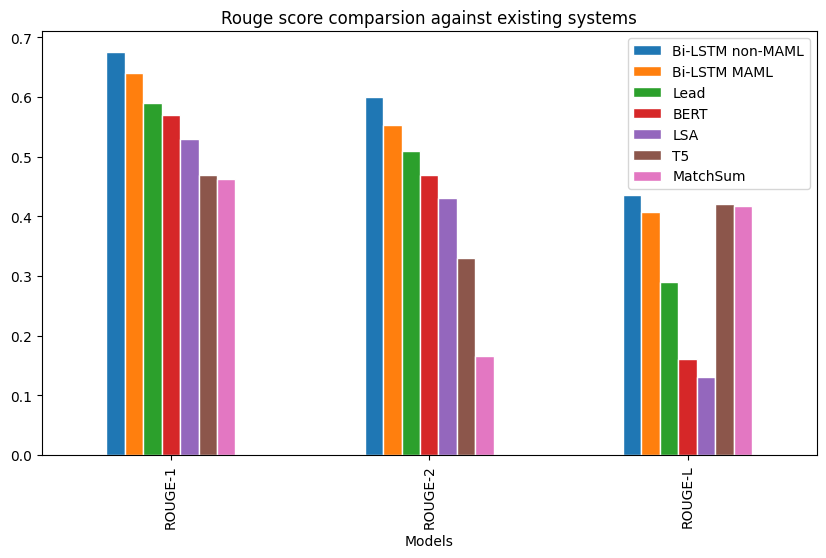

In [183]:
# importing package 
import matplotlib.pyplot as plt 
import pandas as pd 
  
# create data 
df = pd.DataFrame([['ROUGE-1', 0.6762, 0.6398, 0.59, 0.57, 0.53, 0.47, 0.462], ['ROUGE-2',0.5995, 0.5525, 0.51, 0.47, 0.43, 0.33, 0.165], ['ROUGE-L',0.4364, 0.4071, 0.29, 0.16, 0.13, 0.42, 0.418]], 
                  columns=['Models','Bi-LSTM non-MAML','Bi-LSTM MAML', 'Lead', 'BERT', 'LSA', 'T5', 'MatchSum']) 
  
# plot grouped bar chart 
df.plot(x='Models', 
        edgecolor='white',
        kind='bar', 
        stacked=False, 
        title='Rouge score comparsion against existing systems',
        figsize=(10,5.5)) 